### Weather prediction model on BDD dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch.onnx
import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

###  Data preparation

In [3]:
!pwd

/home/ubuntu/efs/Bdd


In [4]:
# set root folder
ROOT = 'data'

In [5]:
import json
with open('bdd100k_label/labels/bdd100k_labels_images_train.json', 'r') as f:
    train_label = json.load(f)

In [6]:
# find the unique weather attributes
l = []
for i in range(len(train_label)):
  l.append(train_label[i]['attributes']['weather'])  

l = set(l)
l

{'clear', 'foggy', 'overcast', 'partly cloudy', 'rainy', 'snowy', 'undefined'}

In [7]:
# create folders for the weather class
data_dir = os.path.join(ROOT, 'imageclasses')

for val in (l):
  if val == 'partly cloudy':
    val_dir = os.path.join(data_dir, 'partly_cloudy')
    os.makedirs(val_dir,  exist_ok = True)
  else:
    val_dir = os.path.join(data_dir, val)
    os.makedirs(val_dir,  exist_ok = True)

In [8]:
# save all images names with their respective attributes in the arrays
clear = []
foggy = [] 
overcast = []
partly_cloudy = [] 
rainy = []
snowy = [] 
undefined = []



for i in range(len(train_label)):
  if train_label[i]['attributes']['weather'] == 'clear':
    clear.append(train_label[i]['name'])
  if train_label[i]['attributes']['weather'] == 'foggy':
    foggy.append(train_label[i]['name'])
  if train_label[i]['attributes']['weather'] == 'overcast':
    overcast.append(train_label[i]['name'])
  if train_label[i]['attributes']['weather'] == 'partly cloudy':
    partly_cloudy.append(train_label[i]['name'])
  if train_label[i]['attributes']['weather'] == 'rainy':
    rainy.append(train_label[i]['name'])
  if train_label[i]['attributes']['weather'] == 'snowy':
    snowy.append(train_label[i]['name'])
  if train_label[i]['attributes']['weather'] == 'undefined':
    undefined.append(train_label[i]['name'])


Each folder in the root directory is the name of a class, and within each of those folders are the images that correspond to that class

In [9]:
from PIL import Image
from os.path import exists

# data sources
data_dir = 'bdd100k/images/100k/train/'
# store images and labels in the directory
image_dst = os.path.join(ROOT, 'imageclasses')


for i in range(len(clear)): # clear directory
  name = clear[i]
  path = data_dir
  image_dst1 = os.path.join(image_dst, 'clear/')
  path = path + name
  image_dst1 = image_dst1 + 'clear_' + name
  if exists(path):
    shutil.copyfile(path, image_dst1)

for i in range(len(foggy)): # foggy directory
  name = foggy[i]
  path = data_dir
  image_dst2 = os.path.join(image_dst, 'foggy/')
  path = path + name
  image_dst2 = image_dst2 + 'foggy_' + name
  if exists(path):
    shutil.copyfile(path, image_dst2)

for i in range(len(overcast)): # overcast directory
  name = overcast[i]
  path = data_dir
  image_dst3 = os.path.join(image_dst, 'overcast/')
  path = path + name
  image_dst3 = image_dst3 + 'overcast_' + name
  if exists(path):
    shutil.copyfile(path, image_dst3)

for i in range(len(partly_cloudy)):  # partly_cloudy directory
  name = partly_cloudy[i]
  path = data_dir
  image_dst4 = os.path.join(image_dst, 'partly_cloudy/')
  path = path + name
  image_dst4 = image_dst4 + 'partly_cloudy_' + name
  if exists(path):
    shutil.copyfile(path, image_dst4)

for i in range(len(rainy)):  # rainy directory
  name = rainy[i]
  path = data_dir
  image_dst5 = os.path.join(image_dst, 'rainy/')
  path = path + name
  image_dst5 = image_dst5 + 'rainy_' + name
  if exists(path):
    shutil.copyfile(path, image_dst5)

for i in range(len(snowy)): #snow directory
  name = snowy[i]
  path = data_dir
  image_dst6 = os.path.join(image_dst, 'snowy/')
  path = path + name
  image_dst6 = image_dst6 + 'snowy_' + name
  if exists(path):
    shutil.copyfile(path, image_dst6)


for i in range(len(undefined)):  #undefined directory
  name = undefined[i]
  path = data_dir
  image_dst7 = os.path.join(image_dst, 'undefined/')
  path = path + name
  image_dst7 = image_dst7 + 'undefined_' + name
  if exists(path):
    shutil.copyfile(path, image_dst7)

In [10]:
TRAIN_RATIO = 0.8
# split images into train and test and save them
images_dir = os.path.join(ROOT, 'imageclasses')
train_dir = os.path.join(ROOT, 'train')
test_dir = os.path.join(ROOT, 'testing')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)
print(len(images_dir))

classes = os.listdir(images_dir)

for c in classes:
    
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
    
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        if image.endswith('.jpg'):
            image_src = os.path.join(class_dir, image)
            image_dst = os.path.join(train_dir, c, image)
            shutil.copyfile(image_src, image_dst)
        
    for image in test_images:
        if image.endswith('.jpg'):
            image_src = os.path.join(class_dir, image)
            image_dst = os.path.join(test_dir, c, image) 
            shutil.copyfile(image_src, image_dst)

In [11]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.2786, 0.2925, 0.2898])
Calculated stds: tensor([0.1975, 0.1981, 0.2008])


In [12]:
pretrained_size = 224
pretrained_means = [0.2786, 0.2925, 0.2898]
pretrained_stds= [0.1975, 0.1981, 0.2008]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

We load our data with our transforms...

In [14]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

...create the validation split...

In [25]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_test_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_test_examples])

...and then overwrite the validation transforms, making sure to do a `deepcopy` to stop this also changing the training data transforms.

In [26]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [27]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 50299
Number of validation examples: 5589
Number of testing examples: 10002


Next, we'll create the iterators with the largest batch size that fits on our GPU. 

In [28]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

To ensure the images have been processed correctly we can plot a few of them - ensuring we re-normalize the images so their colors look right.

In [29]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [30]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

We can see the images look fine, however the names of the classes provided by the folders containing the images are a little long and sometimes overlap with neighbouring images.

['clear', 'foggy', 'overcast', 'partly_cloudy', 'rainy', 'snowy', 'undefined']


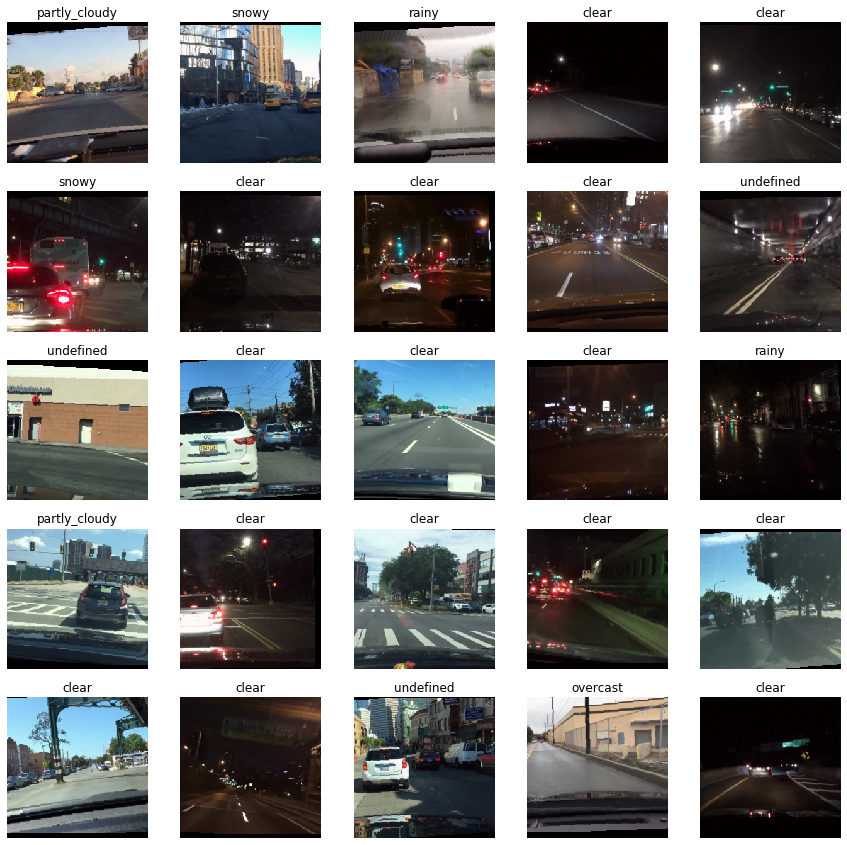

In [31]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes
print(classes)
plot_images(images, labels, classes)

One way to solve the issue with the names of the classes would have been to manually change the names of the folders before we copied them over into the `train` and `test` folders. 

Another approach is to directly change the names of each class provided by the dataset's `.classes`. We'll make a `format_label` function which will strip off the number at the start of each class and convert them into title case.

In [32]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

Let's change the class names and re-plot the images with their new class names.

No more overlapping!

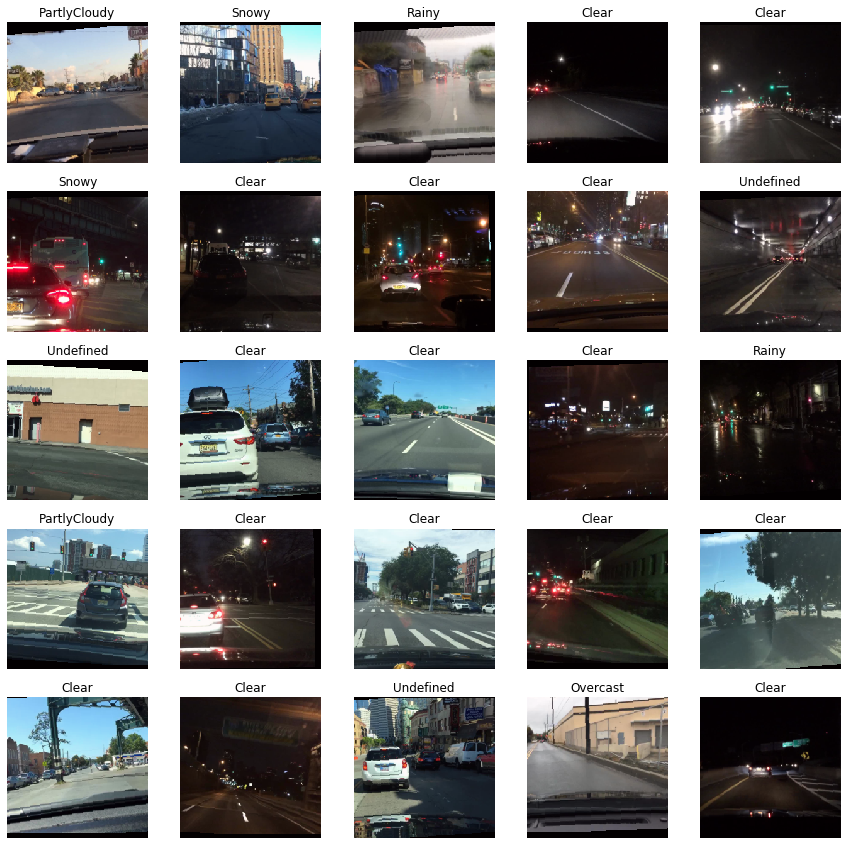

In [33]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

### Defining the Model

Next up, we'll be defining our model. As mentioned previously, we'll be using the residual network (ResNet50 ) model.

In [34]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [35]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x)
        
        return x

In [36]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [37]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

From the ResNet configuration table, we can create the following configurations for ResNet50.
```python
resnet50 = ResNet(resnet50_config, output_dim)
```

In [38]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [39]:
pretrained_model = models.resnet50(pretrained = True)

In [40]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Our dataset, however, only has 7 classes, so we first create a new linear layer with the required dimensions.

In [41]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = 7

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

Then, we replace the pre-trained model's linear layer with our own, randomly initialized linear layer.

In [42]:
pretrained_model.fc = fc

The pre-trained ResNet model provided by torchvision does not provide an intermediate output, which we'd like to potentially use for analysis. We initialized our own ResNet50 model and then utilized the pre-trained parameters into our model srtructure.

We then initialize our ResNet50 model from the configuration...

In [43]:
model = ResNet(resnet50_config, OUTPUT_DIM)

...then we load the parameters (called `state_dict` in PyTorch) of the pre-trained model into our model.

This is also a good sanity check to ensure our ResNet model matches those used by torchvision.

In [44]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [45]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,522,375 trainable parameters


### Training the Model

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

cuda


We can then set the learning rates of our model as LR= 1e-3.
We use the learning rate found by the learning rate finder as the maximum learning rate - used in the final layer - whilst the remaining layers have a lower learning rate, gradually decreasing towards the input. 

In [47]:
LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': LR / 10},
          {'params': model.bn1.parameters(), 'lr': LR / 10},
          {'params': model.layer1.parameters(), 'lr': LR / 8},
          {'params': model.layer2.parameters(), 'lr': LR / 6},
          {'params': model.layer3.parameters(), 'lr': LR / 4},
          {'params': model.layer4.parameters(), 'lr':LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = LR)

In [48]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

One other thing we are going to implement is top-k accuracy, where the prediction is labelled correct if the correct label is in the top-k predictions, instead of just being the first. Our`calculate_topk_accuracy` function calculates the top-1 accuracy as well as the top-k accuracy, with $k=5$ by default.

In [49]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [50]:
def train(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred, _ = model(x)
        
        loss = criterion(y_pred, y)
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [51]:
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

Next, a small helper function which tells us how long an epoch has taken.

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we can train our model!

In [47]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'weather-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 33m 54s
	Train Loss: 0.747 | Train Acc @1:  74.81% | Train Acc @5:  99.02%
	Valid Loss: 0.609 | Valid Acc @1:  79.88% | Valid Acc @5:  99.64%
Epoch: 02 | Epoch Time: 29m 21s
	Train Loss: 0.628 | Train Acc @1:  78.89% | Train Acc @5:  99.64%
	Valid Loss: 0.622 | Valid Acc @1:  79.60% | Valid Acc @5:  99.54%
Epoch: 03 | Epoch Time: 30m 36s
	Train Loss: 0.623 | Train Acc @1:  79.14% | Train Acc @5:  99.67%
	Valid Loss: 0.617 | Valid Acc @1:  79.71% | Valid Acc @5:  99.64%
Epoch: 04 | Epoch Time: 30m 16s
	Train Loss: 0.588 | Train Acc @1:  79.98% | Train Acc @5:  99.66%
	Valid Loss: 0.604 | Valid Acc @1:  80.07% | Valid Acc @5:  99.56%
Epoch: 05 | Epoch Time: 29m 30s
	Train Loss: 0.565 | Train Acc @1:  80.68% | Train Acc @5:  99.77%
	Valid Loss: 0.571 | Valid Acc @1:  81.05% | Valid Acc @5:  99.68%
Epoch: 06 | Epoch Time: 29m 24s
	Train Loss: 0.538 | Train Acc @1:  81.75% | Train Acc @5:  99.79%
	Valid Loss: 0.546 | Valid Acc @1:  81.46% | Valid Acc @5:  99.65%
Epoc

The test accuracies are a little lower than the validation accuracies, but not by so much that we should be concerned.

In [32]:
model.load_state_dict(torch.load('weather-model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

Test Loss: 0.531 | Test Acc @1:  82.34% | Test Acc @5:  99.85%


### Examining the Model
First, we get the predictions for each image in the test set...

In [44]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [45]:
images, labels, probs = get_predictions(model, test_iterator)

... which we then use to get the predicted labels.

In [46]:
pred_labels = torch.argmax(probs, 1)

### confusion_matrix

In [72]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (8, 8));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90, fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('Predicted Label', fontsize = 20)
    plt.ylabel('True Label', fontsize = 20)

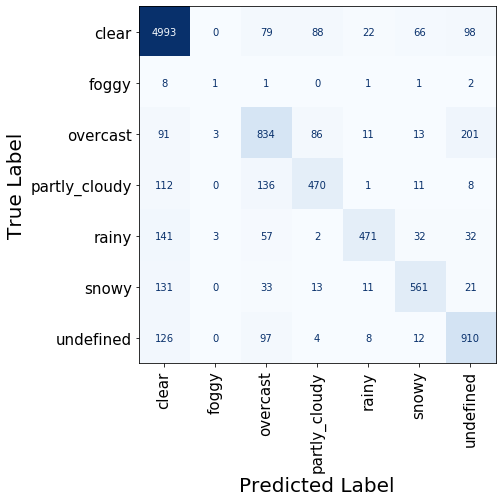

In [73]:
plot_confusion_matrix(labels, pred_labels, classes)

We can then get all of the correct predictions, filter them out, and then sort all of the incorrect predictions based on how confident they were on their incorrect prediction.

In [74]:
corrects = torch.eq(labels, pred_labels)

In [75]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then plot the most incorrectly predicted images along with the predicted class and the actual class. 

In [76]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace=0.4)

From the names of the classes we can see that the incorrect predictions are usually the undefined and the clear classes.

Some of the night time images are kind of confuses the model between undefined, rainy, snowy and clear classes as it is difficult to predict and mostly depends on the annotation of the images.

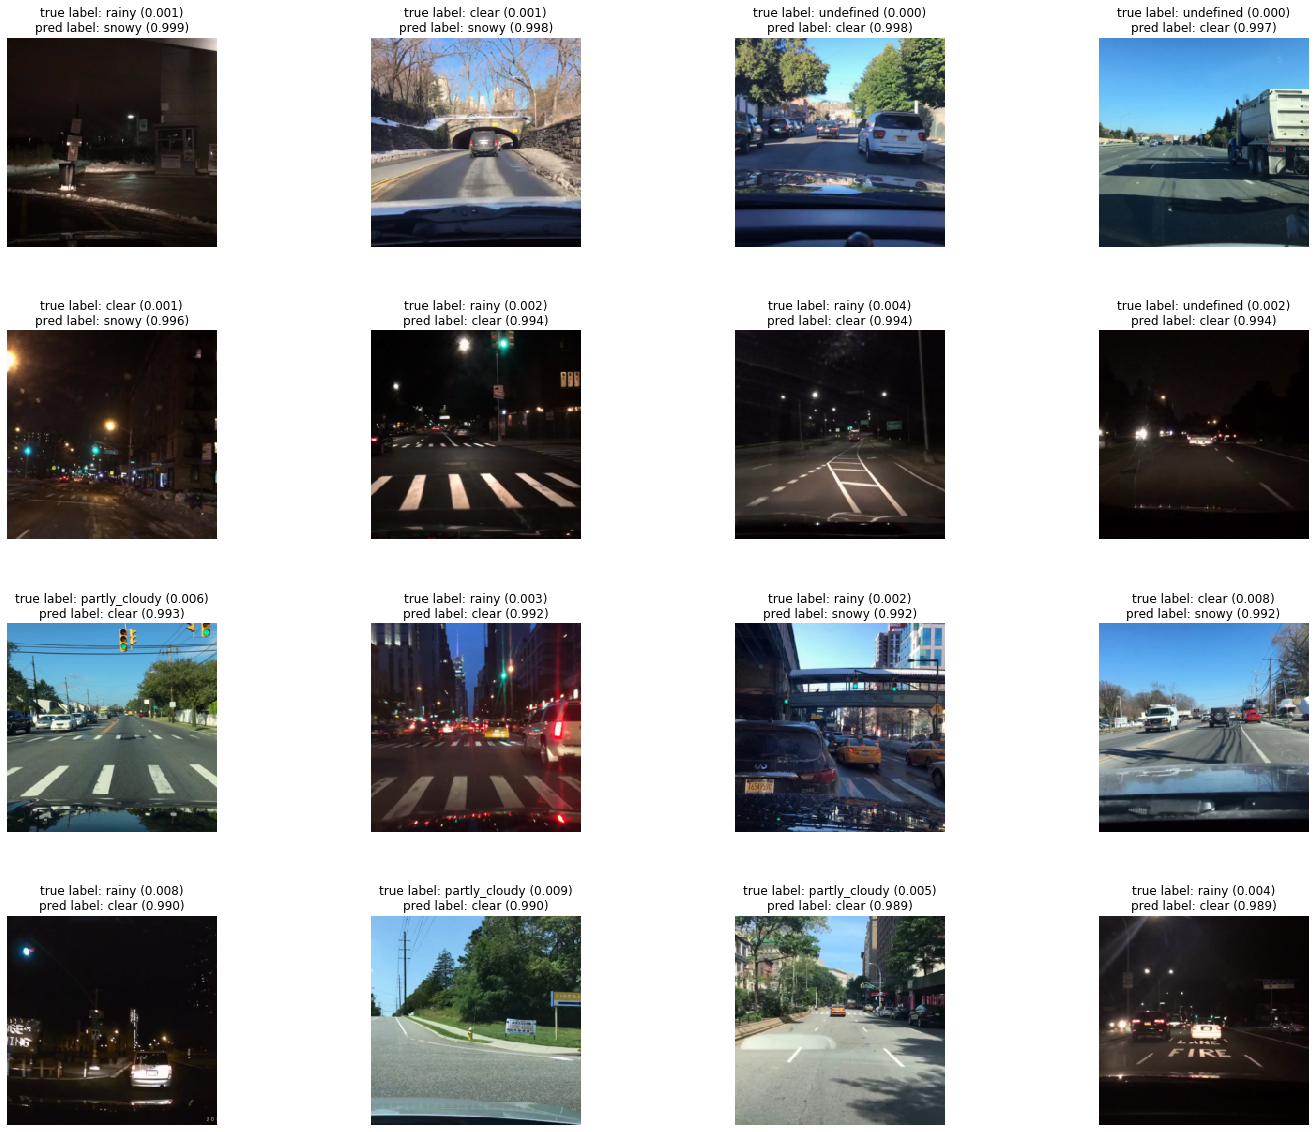

In [78]:
N_IMAGES = 20

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

We can then plot what a few of the images look like after having gone through the first convolutional layer.

In [86]:
def plot_filtered_images(images, filters, n_filters = None, normalize = True):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    if n_filters is not None:
        filters = filters[:n_filters]

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (30, 30))

    for i in range(n_images):

        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(image.permute(1,2,0).numpy())
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]

            if normalize:
                image = normalize_image(image)

            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

    fig.subplots_adjust(hspace = -0.7)

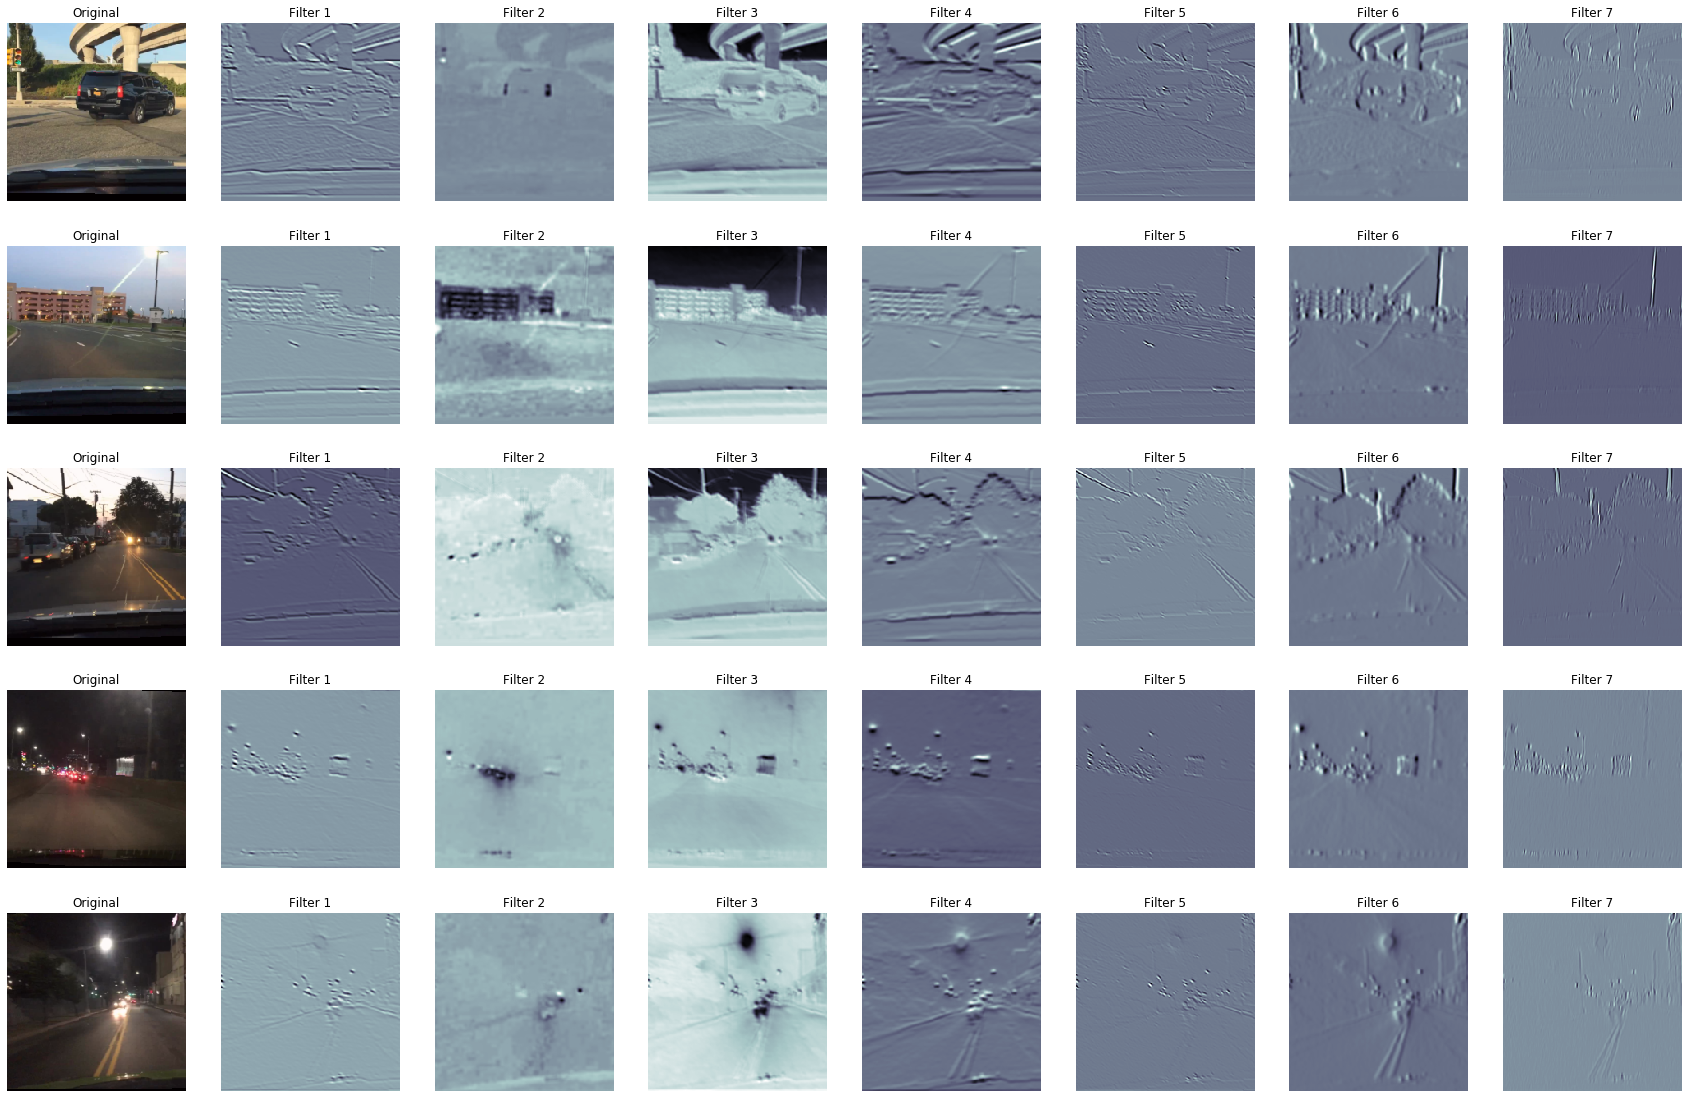

In [87]:
N_IMAGES = 5
N_FILTERS = 7

images = [image for image, label in [train_data[i] for i in range(N_IMAGES)]]
filters = model.conv1.weight.data

plot_filtered_images(images, filters, N_FILTERS)

Finally, we can plot the values of the filters themselves.

In [88]:
def plot_filters(filters, normalize = True):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    rows = int(np.sqrt(n_filters))
    cols = int(np.sqrt(n_filters))

    fig = plt.figure(figsize = (30, 15))

    for i in range(rows*cols):

        image = filters[i]

        if normalize:
            image = normalize_image(image)

        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.axis('off')
        
    fig.subplots_adjust(wspace = -0.9)

There are some interesting patterns contained in these filters, however all of these were already present in the pre-trained ResNet model. The learning rate used on this initial convolutional layer was most probably too small to change these significantly.

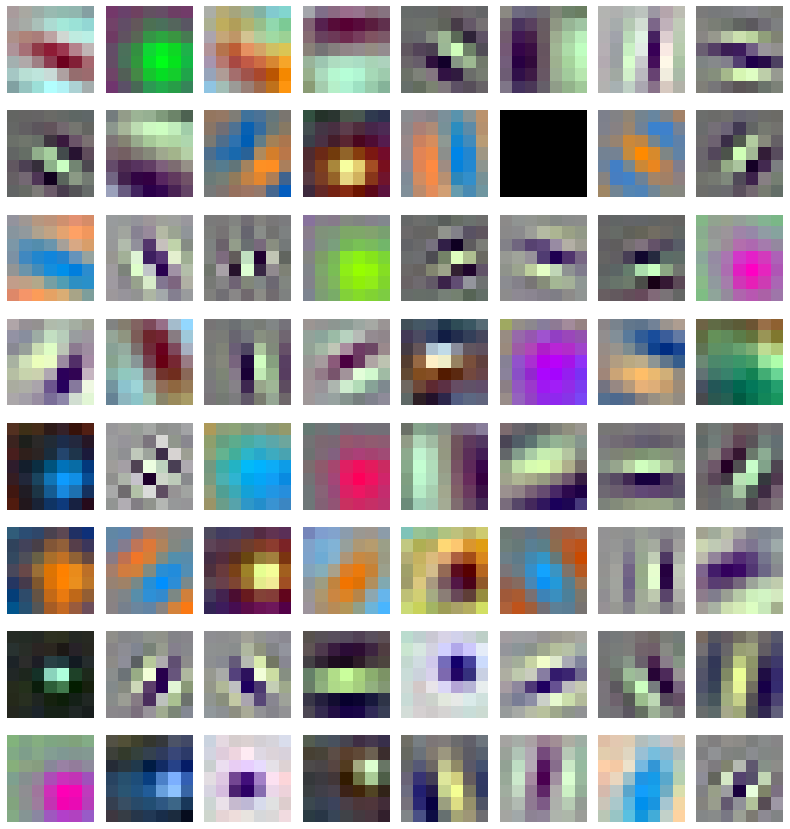

In [89]:
plot_filters(filters)

# Store the model in ONNX format

In [53]:
# Load pretrained model weights
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
model.load_state_dict(torch.load('weather-model.pt'))

# set the model to inference mode
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
# Input to the model
x = torch.randn(batch_size, 3, 224, 224, requires_grad=True).to(device)
torch_out = model(x)

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "weather.onnx",            # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

## Prediction on a random sample image

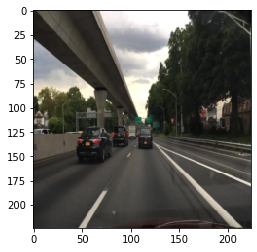

In [66]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

img=Image.open("sample.jpg")
resize = transforms.Resize([224, 224])
img = resize(img)
plt.imshow(img) 

## Predicted class = overcast

In [76]:
transform = transforms.ToTensor()
input = transform(img).to(device)
input = input.unsqueeze(0)
print(input.shape)
output = model(input)
print(output)

torch.Size([1, 3, 224, 224])
(tensor([[ 0.0548, -2.4460,  1.5713, -1.2171, -3.2678, -2.2713,  0.9141]],
       device='cuda:0', grad_fn=<AddmmBackward>), tensor([[0.0714, 0.0055, 0.0018,  ..., 0.0066, 0.3164, 0.1261]],
       device='cuda:0', grad_fn=<ViewBackward>))


From the labels we can see it predicted the image as Overcast class accurately